## Project 6

In [191]:
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from sklearn.externals.six import StringIO
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder

import scipy
import requests
from imdbpie import Imdb
import matplotlib.pyplot as plt
import urllib
from bs4 import BeautifulSoup
import nltk
import collections
import re
import csv
import psycopg2

import io
from scipy import misc

import sqlalchemy
import pydot

import string
import seaborn as sns



from IPython.display import Image



%reload_ext sql


%matplotlib inline

### Pre-Work: Write a problem statement 

My boss wants to get the top 25 movies from IMDB and analyze their reviews to see how people describe them. My boss hopes to use these descriptors to suggest other movies with similar descriptors to our users. First we need to see these words can be used to predict a movie's rating.

## Part 1: Acquire the Data

#### 1. Connect to the IMDB API

In [192]:
imdb = Imdb()
imdb = Imdb(anonymize=True)

#### 2. Query the top 250 rated movies in the database

In [193]:
imdbjson = imdb.top_250()
imdbjson

[{u'can_rate': True,
  u'image': {u'height': 1388,
   u'url': u'http://ia.media-imdb.com/images/M/MV5BODU4MjU4NjIwNl5BMl5BanBnXkFtZTgwMDU2MjEyMDE@._V1_.jpg',
   u'width': 933},
  u'num_votes': 1677724,
  u'rating': 9.3,
  u'tconst': u'tt0111161',
  u'title': u'The Shawshank Redemption',
  u'type': u'feature',
  u'year': u'1994'},
 {u'can_rate': True,
  u'image': {u'height': 500,
   u'url': u'http://ia.media-imdb.com/images/M/MV5BMjEyMjcyNDI4MF5BMl5BanBnXkFtZTcwMDA5Mzg3OA@@._V1_.jpg',
   u'width': 333},
  u'num_votes': 1147897,
  u'rating': 9.2,
  u'tconst': u'tt0068646',
  u'title': u'The Godfather',
  u'type': u'feature',
  u'year': u'1972'},
 {u'can_rate': True,
  u'image': {u'height': 500,
   u'url': u'http://ia.media-imdb.com/images/M/MV5BNDc2NTM3MzU1Nl5BMl5BanBnXkFtZTcwMTA5Mzg3OA@@._V1_.jpg',
   u'width': 333},
  u'num_votes': 784896,
  u'rating': 9,
  u'tconst': u'tt0071562',
  u'title': u'The Godfather: Part II',
  u'type': u'feature',
  u'year': u'1974'},
 {u'can_rate': True,
 

#### 3. Only select the top 25 movies and delete the uncessary rows

In [194]:
movieDF = pd.io.json.DataFrame(imdbjson)

del movieDF["image"]
del movieDF["can_rate"]

#### 4. Write the Results to a csv

In [195]:
movieDF = movieDF.iloc[0:100,:]
movieDF.to_csv("../assets/data/top25Movies.csv",encoding='utf-8',index = False, header=True)
movieDF.head()

,num_votes,rating,tconst,title,type,year
0,1677724,9.3,tt0111161,The Shawshank Redemption,feature,1994
1,1147897,9.2,tt0068646,The Godfather,feature,1972
2,784896,9.0,tt0071562,The Godfather: Part II,feature,1974
3,1662960,9.0,tt0468569,The Dark Knight,feature,2008
4,858604,8.9,tt0108052,Schindler's List,feature,1993


## Part 2: Wrangle the text data

#### 1. Convert the listing identification numbers (tconst) from the first dataframe to a list

In [196]:
tconstList = movieDF.tconst
tconstList

0     tt0111161
1     tt0068646
2     tt0071562
3     tt0468569
4     tt0108052
5     tt0050083
6     tt0110912
7     tt0167260
8     tt0060196
9     tt0137523
10    tt0120737
11    tt0080684
12    tt0109830
13    tt1375666
14    tt0167261
15    tt0073486
16    tt0099685
17    tt0133093
18    tt0047478
19    tt0076759
20    tt0317248
21    tt0114369
22    tt0102926
23    tt0038650
24    tt0114814
25    tt0118799
26    tt0110413
27    tt0064116
28    tt0245429
29    tt0120815
        ...    
70    tt0052357
71    tt0051201
72    tt0086190
73    tt0022100
74    tt0105236
75    tt0112573
76    tt0211915
77    tt0180093
78    tt0066921
79    tt0075314
80    tt0036775
81    tt0435761
82    tt0056172
83    tt0056592
84    tt0338013
85    tt0093058
86    tt0086879
87    tt0070735
88    tt0062622
89    tt0040522
90    tt0045152
91    tt0114709
92    tt0208092
93    tt0071853
94    tt0361748
95    tt0012349
96    tt0119488
97    tt0059578
98    tt0042876
99    tt0053604
Name: tconst, dtype: obj

#### 2. Get Reviews using imdpie api call

*Hint*: Use a loop to scrape each page at once

This code calls imdpie to get a movies' reviews

In [197]:
usernameList = []
textList = []
dateList = []
ratingList = []
summaryList = []
statusList = []
user_locationList = []
user_scoreList = []
user_score_countList = []
tconstList2 = []

for item in tconstList:
    reviews = imdb.get_title_reviews(item, max_results=15)
    for review in reviews:
        tconstList2.append(item)
        usernameList.append(review.username)
        textList.append(review.text)
        dateList.append(review.date)
        ratingList.append(review.rating)
        summaryList.append(review.summary)
        statusList.append(review.status)
        user_locationList.append(review.user_location)
        user_scoreList.append(review.user_score)
        user_score_countList.append(review.user_score_count)

In [198]:
reviewsDF = pd.DataFrame({
        'tconst':tconstList2,
        'username':usernameList,
        'text':textList,
        'date':dateList,
        'rating':ratingList,
        'summary':summaryList,
        'status':statusList,
        'user_location':user_locationList,
        'user_score':user_scoreList,
        'user_score_count':user_score_countList
            })
reviewsDF.head()

,date,rating,status,summary,tconst,text,user_location,user_score,user_score_count,username
0,2003-11-26,10.0,G,Tied for the best movie I have ever seen,tt0111161,Why do I want to write the 234th comment on Th...,Texas,2102.0,2421.0,carflo
1,2002-08-27,10.0,G,Shawshank Redeems Hollywood,tt0111161,"\nCan Hollywood, usually creating things for e...","Paducah, KY",1380.0,1613.0,Wesley S. Walker
2,2001-02-08,NaN,G,Prepare to be moved,tt0111161,\nI have never seen such an amazing film since...,"Westerville, Ohio",1248.0,1449.0,speedreid
3,2006-02-10,10.0,S,A classic piece of unforgettable film-making.,tt0111161,"In its Oscar year, Shawshank Redemption (writt...","Vancouver, Canada",876.0,992.0,Justin M (kaspen12)
4,1998-08-16,NaN,S,Two movies in one,tt0111161,The reason I became a member of this database ...,"Chicago, IL",920.0,1141.0,Douglas-2


#### 3. Work through each title and find the most common descriptors

This commented out code works, but I wanted a little more control over which words were picked.

In [199]:
# vectorizer = CountVectorizer(max_features=10,stop_words="english")
# vectorizer.fit(revixewsDF.text)

In [200]:
# vectorDF  = pd.DataFrame(vectorizer.transform(reviewsDF.text).todense(),
#              columns=vectorizer.get_feature_names())
# vectorDF.head()

In [201]:
# combinedDF = reviewsDF.join(movieDF)
# combinedDF

This code downloads the needed corpi to analyze words, it gets sets english stop words. Also getting punctuation from string lib

In [202]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
stop = nltk.corpus.stopwords.words('english')
punc = list(string.punctuation)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alexandertam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexandertam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alexandertam/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexandertam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


this code generate a dictionary of words that occur in the reviews for the selection movies
    1. tokenize review
    2. remove stopwords and punctuation
    3. tag remainging words with word type ( noun, adj, adv, etc )
    4. keep adj and related
    5. generate frequency distribution
    6. add new tokens to master

In [203]:
tokenDictionary = collections.Counter()

for reviewText in reviewsDF.text:
    listOfTokens = nltk.word_tokenize(reviewText.lower())
    listOfTokens = [token for token in listOfTokens if token not in stop and token not in punc]
    listOfTokenTags = nltk.pos_tag(listOfTokens)
    for tag in listOfTokenTags:
        key, value = tag
        if "JJ" not in value:
            listOfTokens.remove(key)
    freqDist = nltk.probability.FreqDist(listOfTokens)
    freqDistDict = dict(freqDist.items())
    newTokens = collections.Counter(freqDistDict)
    tokenDictionary = tokenDictionary + newTokens


In [204]:
# listOfTokenTags = nltk.pos_tag(listOfTokens)
# for tag in listOfTokenTags:
#     key, value = tag
#     print tag

# listOfTokenT= nltk.pos_tag(listOfTokens)
# for token in listOfTokens:
#     print token
    
            

In [205]:
mostCommon = tokenDictionary.most_common(15)
print mostCommon

[(u'great', 1128), (u'best', 980), (u'good', 910), (u'many', 903), (u'first', 635), (u'much', 615), (u'little', 494), (u'new', 435), (u'real', 371), (u'last', 333), (u'true', 327), (u'different', 310), (u'bad', 301), (u'human', 297), (u'old', 291)]


This function looks at each token and finds its synonyms. then it removes the synonyms
This function probably goes overboard on eliminating redundant meanings. From here I will create two dataframes with different word selection. One will use no synonym elimination and the other will use the below function

In [206]:
def RemoveWordsWithSameMeanings(tokenDictionary):
    for key in tokenDictionary.keys():
        synonyms = []

        for syn in nltk.corpus.wordnet.synsets(key):
            for l in syn.lemmas():
                synonyms.append(l.name())

        for synonym in list(set(synonyms)):
            try:
                tokenDictionary.pop(synonym.encode('ascii','ignore'))
            except:
                pass
    return tokenDictionary
        
tokenDictionary = RemoveWordsWithSameMeanings(tokenDictionary)

In [207]:
mostCommonNonSynonym = tokenDictionary.most_common(15)
print mostCommonNonSynonym

[(u'american', 247), (u'german', 123), (u'french', 96), (u'scorsese', 81), (u'english', 79), (u'finest', 72), (u'forrest', 68), (u'japanese', 68), (u'sci-fi', 65), (u'jewish', 59), (u'italian', 51), (u'british', 49), (u'andy', 48), (u'wall-e', 42), (u'michael', 40)]


#### 4. Convert to a Dataframe for Easy Viewing

This function builds the table with title and tconst as identifiers and word columns.
This word columns contain 0 or 1. 1 indicating that word appeared in a review for that movie

In [89]:
def ConstructSentimentTable(movieDF,reviewsDF,sentimentWords): 
    columnNames = ["title","tconst"]
    mostCommonWords = []

    for common in sentimentWords:
        key, _ = common
        mostCommonWords.append(key)

    columnNames = columnNames + mostCommonWords

    master = []
    for index, movie in movieDF.iterrows():
        identity = [movie["title"],movie["tconst"]]
        for word in mostCommonWords:
            #print reviewsDF[reviewsDF["tconst"] ==  movie["tconst"]].text.tolist()
            if word in str(reviewsDF[reviewsDF["tconst"] ==  movie["tconst"]].text.tolist()):
                identity.append(1)
            else:
                identity.append(0)
        master.append(identity)

    movieSentimentDF = pd.DataFrame(master,columns=columnNames)
    return movieSentimentDF

movieSentimentDF = ConstructSentimentTable(movieDF,reviewsDF,mostCommon)
movieSentimentNonSynonymDF = ConstructSentimentTable(movieDF,reviewsDF,mostCommonNonSynonym)
movieSentimentDF.head()

,title,tconst,great,best,good,many,first,much,little,new,real,last,true,different,bad,human,old
0,The Shawshank Redemption,tt0111161,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,The Godfather,tt0068646,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,The Godfather: Part II,tt0071562,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
3,The Dark Knight,tt0468569,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,Schindler's List,tt0108052,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


#### 6. Write the results to a csv

In [90]:
movieSentimentDF.to_csv("../assets/data/top25MovieSentiments.csv",encoding='utf-8',index=False,header=True)

## Part 3: Combine Tables in PostgreSQL

#### 1. Import your two .csv data files into your Postgre Database as two different tables

For ease, we can call these table1 and table2

#### 2. Connect to database and query the joined set

This code install homebrew and homebrew services, this will be use to start and stop postgres

In [91]:
!/usr/bin/ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"
!brew tap homebrew/services
#!psql postgres


It appears Homebrew is already installed. If your intent is to reinstall you
should do the following before running this installer again:
    ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/uninstall)"
The current contents of /usr/local are bin Cellar CODEOFCONDUCT.md etc include lib Library LICENSE.txt opt pgsql README.md share var .git .github .gitignore


The below section of code has been commented out. it worked but return duplicate rows for some black magic reason I could not figure out. SQLAlchemy is amazing and infinitely better.

### Add tables

In [92]:
#!brew services start postgresql

In [93]:
# try:
#     conn = psycopg2.connect("dbname='postgres' user='alexandertam' host='localhost'")
# except:
#     print "I am unable to connect to the database"

In [94]:
# cur = conn.cursor()

In [95]:
# create table1 (movies)

# cur.execute("""CREATE TABLE IF NOT EXISTS table1(num_votes integer, rating decimal, tconst varchar, title varchar, type varchar, year varchar)""")

In [96]:
# delete rows from table
# cur.execute("""TRUNCATE TABLE table1""")

In [97]:
# cur.execute("""SELECT * FROM table1""")
# tableOne = cur.fetchall()
# print len(tableOne)
# print tableOne

In [98]:
# load table1 with data

# cur.execute("""COPY table1 FROM '/Users/alexandertam/DSI/curriculum/02-projects/01-projects-weekly/project-06/assets/data/top25Movies.csv' DELIMITER ',' CSV;""")

In [99]:
# cur.execute("""SELECT * FROM table1""")
# tableOne = cur.fetchall()
# print len(tableOne)
# print tableOne

In [100]:
# # create table2 ()

# cur.execute('''CREATE TABLE IF NOT EXISTS table2 
# (title varchar, tconst varchar, great varchar, best varchar, many varchar, good varchar, first varchar, much varchar, new varchar, little varchar, real varchar, true_word varchar);''')

In [101]:
# delete rows from table
# cur.execute("""TRUNCATE TABLE table2""")

In [102]:
# cur.execute("""SELECT * FROM table2""")
# tableTwo = cur.fetchall()
# print len(tableTwo)
# print tableTwo

In [103]:
# load table2 with data

# cur.execute('''COPY table2 FROM '/Users/alexandertam/DSI/curriculum/02-projects/01-projects-weekly/project-06/assets/data/top25MovieSentiments.csv' DELIMITER ',' CSV;''')

In [104]:
# cur.execute("""SELECT * FROM table2""")
# tableTwo = cur.fetchall()
# print len(tableTwo)
# print tableTwo

In [105]:
# cur.close()

In [106]:
# conn.close()

### Join Tables

In [107]:
#!brew services stop postgresql

In [108]:
# # declare these out of scope of connection
# joined1 = pd.DataFrame()
# joined2 = pd.DataFrame()
# columnNames = []
# columnTypes = []

In [109]:
#!brew services start postgresql

In [110]:
# try:
#     conn = psycopg2.connect("dbname='postgres' user='alexandertam' host='localhost'")
# except:
#     print "I am unable to connect to the database"

In [111]:
# cur = conn.cursor()

In [112]:
# cur.execute("""SELECT * FROM table1""")
# tableOne = cur.fetchall()
# print len(tableOne)
# print tableOne

In [113]:
# cur.execute("""SELECT * FROM table2""")
# tableTwo = cur.fetchall()
# print len(tableTwo)
# print tableTwo

In [114]:
# cur.execute(
#     '''
#     SELECT *
#     FROM table1 as m
#     INNER JOIN table2 as r
#     ON m."tconst"=r."tconst";
#     ''')

In [115]:
#cselect column_name, data_type from information_schema.columns where table_name = 'config';

In [116]:
# joinedTable = cur.fetchall()
# columnNames = [desc[0] for desc in cur.description]
# joined1 = pd.DataFrame(joinedTable,columns=columnNames)
# joined2 = pd.DataFrame(joinedTable,columns=columnNames)

In [117]:
# cur.close()

In [118]:
# conn.close()

In [119]:
# !brew services stop postgresql

Get user that is logged in, to pass to connection string

In [219]:
user = !id -un
print user[0]

alexandertam


This code starts the local postgres db and adds to new tables to the database. It will drop/truncate the table if one already exisits with the same name

In [220]:
!brew services start postgresql
engine = sqlalchemy.create_engine('postgresql://' + user[0] + '@localhost:5432/postgres')

movieDF.to_sql("table1",con = engine, if_exists = "replace")
movieSentimentDF.to_sql("table2",con = engine, if_exists = "replace")
movieSentimentNonSynonymDF.to_sql("table3",con = engine, if_exists = "replace")


==> Successfully started `postgresql` (label: homebrew.mxcl.postgresql)


This code joines table with table2 and table1 with table 3. its join movie data with movie sentiment data

In [221]:
joined = pd.read_sql("SELECT * FROM table1 as m JOIN table2 as r ON m.tconst=r.tconst;",con = engine)
joinedNonSynonym = pd.read_sql("SELECT * FROM table1 as m JOIN table3 as r ON m.tconst=r.tconst;",con = engine)


This stops the local postgres database

In [222]:
!brew services stop postgresql

Stopping `postgresql`... (might take a while)
==> Successfully stopped `postgresql` (label: homebrew.mxcl.postgresql)


## Part 4: Parsing and Exploratory Data Analysis

#### 1. Clean the data

In [223]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 25 columns):
index        100 non-null int64
num_votes    100 non-null int64
rating       100 non-null float64
tconst       100 non-null object
title        100 non-null object
type         100 non-null object
year         100 non-null object
index        100 non-null int64
title        100 non-null object
tconst       100 non-null object
great        100 non-null int64
best         100 non-null int64
good         100 non-null int64
many         100 non-null int64
first        100 non-null int64
much         100 non-null int64
little       100 non-null int64
new          100 non-null int64
real         100 non-null int64
last         100 non-null int64
true         100 non-null int64
different    100 non-null int64
bad          100 non-null int64
human        100 non-null int64
old          100 non-null int64
dtypes: float64(1), int64(18), object(6)
memory usage: 19.6+ KB


In [224]:
joined.corr()

,index,num_votes,rating,index,great,best,good,many,first,much,little,new,real,last,true,different,bad,human,old
index,1.000000,-0.588699,-0.910231,1.000000,NaN,NaN,-0.113156,NaN,NaN,NaN,0.164411,-0.033508,NaN,-0.163976,0.059235,0.154625,0.060765,-0.203169,-0.053967
num_votes,-0.588699,1.000000,0.636291,-0.588699,NaN,NaN,0.103097,NaN,NaN,NaN,-0.175644,0.100020,NaN,0.048020,-0.032497,0.015647,0.133009,0.159626,0.059952
rating,-0.910231,0.636291,1.000000,-0.910231,NaN,NaN,0.064599,NaN,NaN,NaN,-0.166983,-0.001142,NaN,0.133094,-0.069719,-0.063151,0.012587,0.148154,0.064599
index,1.000000,-0.588699,-0.910231,1.000000,NaN,NaN,-0.113156,NaN,NaN,NaN,0.164411,-0.033508,NaN,-0.163976,0.059235,0.154625,0.060765,-0.203169,-0.053967
great,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
best,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
good,-0.113156,0.103097,0.064599,-0.113156,NaN,NaN,1.000000,NaN,NaN,NaN,-0.020515,-0.017675,NaN,-0.033501,0.285878,-0.025392,-0.037113,0.285878,-0.010101
many,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
much,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


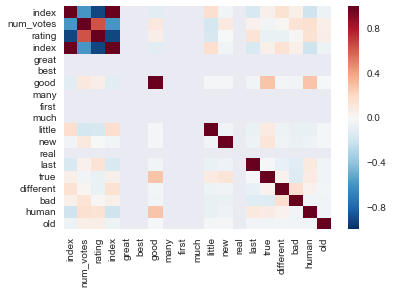

In [225]:
sns.heatmap(joined.corr())

Above, the correlation matrix has many NaNs. The correlation computation was unable to find correlation because all the values for that word were the same. The gray areas on the heatmap are the NaNs

The function removes columns from the data from that are not predictors and normalize certain fields to increase model score later when models are run.

In [226]:
def formatDataFrame(df):
    try:
        del df["index"] #identifier
        del df["title"]  #identifier
        del df["tconst"] #identifier
        del df["type"] #all of them are features 
        #del df["num_votes"] keep this field, indicates some sort of popularity/notoriety
    except:
        print "Probably already deleted."
    
    #normalize year for better score
    df["year"] = preprocessing.MinMaxScaler().fit_transform(df.year.astype(float).reshape(-1,1))
    #df["num_votes"] = preprocessing.MinMaxScaler().fit_transform(df.num_votes.astype(float).reshape(-1,1))
    #normalize rating for better score
    df["rating"] = preprocessing.MinMaxScaler().fit_transform(df.rating.astype(float).reshape(-1,1))
    
    return df

joined = formatDataFrame(joined)
print joined.columns
joinedNonSynonym = formatDataFrame(joinedNonSynonym)
print joinedNonSynonym.columns

Index([u'num_votes', u'rating', u'year', u'great', u'best', u'good', u'many',
       u'first', u'much', u'little', u'new', u'real', u'last', u'true',
       u'different', u'bad', u'human', u'old'],
      dtype='object')
Index([u'num_votes', u'rating', u'year', u'american', u'german', u'french',
       u'scorsese', u'english', u'finest', u'forrest', u'japanese', u'sci-fi',
       u'jewish', u'italian', u'british', u'andy', u'wall-e', u'michael'],
      dtype='object')


This function returns true if a list only contains the same value.
We then remove these columns from our data frames

In [227]:
def checkEqual(iterator):
    return len(set(iterator)) <= 1

for columnTitle in joined.columns.values:
    if(checkEqual(joined[columnTitle].values)):
        del joined[columnTitle]

for columnTitle in joinedNonSynonym.columns.values:
    if(checkEqual(joinedNonSynonym[columnTitle].values)):
        del joinedNonSynonym[columnTitle]


In [228]:
joined1 = joined
joined2 = joinedNonSynonym
joined1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
num_votes    100 non-null int64
rating       100 non-null float64
year         100 non-null float64
good         100 non-null int64
little       100 non-null int64
new          100 non-null int64
last         100 non-null int64
true         100 non-null int64
different    100 non-null int64
bad          100 non-null int64
human        100 non-null int64
old          100 non-null int64
dtypes: float64(2), int64(10)
memory usage: 9.4 KB


#### 3. Visualize the Data

Our heatmaps for our two word choices now have no gray areas. We removed that words that appeared in every movies' reviews. These words do no differenciate their movies if it occurs for all the top movies

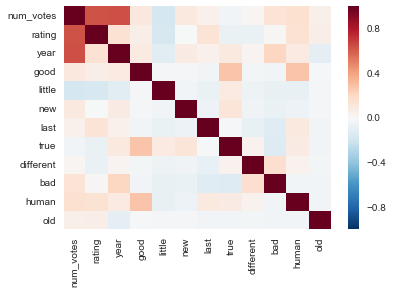

In [229]:
sns.heatmap(joined1.corr())

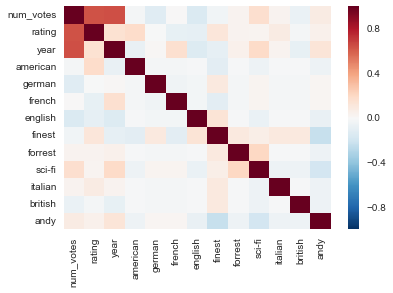

In [230]:
sns.heatmap(joined2.corr())

In both of our above heat maps, we can see a correlation between num_votes and rating, and num_votes and year. This makes sense. The more votes a movie receives indicates its motivate users to vote for it. And because year is correlated with num_votes, we can assume the site gained more users over the years.

Some words have mild positive correlation to each other while others had mild negative correlation. It would be hard to extrapolate exactly why. Some words just occur more often together in writing than others.

## Part 3: Build the Decision Tree

#### 1. What is our target attribute? 

Our target is a normalized rating

#### 2. Prepare the data and define the training set

In [231]:
joined1

,num_votes,rating,year,good,little,new,last,true,different,bad,human,old
0,1677724,1.0,0.784946,1,1,1,1,1,1,1,1,1
1,1147897,0.9,0.548387,1,1,1,1,1,1,1,1,1
2,784896,0.7,0.569892,1,1,1,1,1,1,1,0,1
3,1662960,0.7,0.935484,1,1,1,1,1,1,1,1,1
4,858604,0.6,0.774194,1,1,1,1,1,1,1,1,1
5,443803,0.6,0.387097,1,1,1,1,1,1,1,1,1
6,1315100,0.6,0.784946,1,0,1,1,0,1,1,1,1
7,1207290,0.6,0.881720,1,1,1,1,1,1,1,1,1
8,499951,0.6,0.483871,1,1,0,1,0,1,1,1,1
9,1337013,0.6,0.838710,1,1,1,1,1,1,1,1,1


This fucntion divides a dataframe into its predictors and targets

In [232]:
def getXy(df,target):
    dftemp = pd.DataFrame()
    dftemp = df
    y = 0
    try:
        y = dftemp[target]
        del dftemp[target]
    except:
        pass
    X = dftemp
    return (X,y)

X1, y1 = getXy(joined1,"rating")
X2, y2 = getXy(joined2,"rating")

Generate train test variables for both word sets

In [233]:
X1train, X1test, y1train, y1test = train_test_split(X1,y1, test_size=0.3, random_state = 7)
X2train, X2test, y2train, y2test = train_test_split(X2,y2, test_size=0.3, random_state = 7)

### Decision Tree - All Data

In [234]:
model = DecisionTreeRegressor()
model.fit(X1,y1)
yHat = model.predict(X1)
model.score(X1,yHat)

1.0

1 is a perfect score. It should not be one, I don't know how to explain this. Our data must be biased because of the way we are slicing our movie data

In [235]:
dt = pd.DataFrame({'feature':X1.columns, 'importance':model.feature_importances_})
dt

,feature,importance
0,num_votes,0.693914
1,year,0.188214
2,good,0.000000
3,little,0.001186
4,new,0.000000
5,last,0.033708
6,true,0.009879
7,different,0.026368
8,bad,0.014888
9,human,0.031844


The above feature importance datatable tells us that our words are bad. Only year and num_votes have significant influence. We should pick better words or perhaps a wider spread of movie ratings

The code below should generate a tree graph visualization but I'm  running into issues with.

In [236]:
!brew install graphviz

In [238]:
dot_data = StringIO()  
export_graphviz(model, out_file=dot_data,  
                feature_names=X1.columns,  
                filled=True, rounded=True,
                proportion=True,
                special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

UnicodeDecodeError: 'ascii' codec can't decode byte 0xef in position 0: ordinal not in range(128)

### Train Test Split

Split data into training and test data

In [174]:
model = DecisionTreeRegressor()
model.fit(X1train,y1train)
yHat = model.predict(X1test)
model.score(X1test,yHat)

1.0

I still get 1, this is wierd.

In [173]:
pd.DataFrame({'feature':X1train.columns, 'importance':model.feature_importances_})

,feature,importance
0,num_votes,0.704964
1,year,0.180555
2,good,0.000000
3,little,0.001196
4,new,0.013354
5,last,0.034879
6,true,0.000000
7,different,0.016433
8,bad,0.015816
9,human,0.032803


Same as before train test split

# Cross Validation

### Decision Tree

set number of cv using the KFOLD method

In [175]:
cv = KFold(len(y1),shuffle=False)

dt = DecisionTreeRegressor(random_state=5)
dtScore = cross_val_score(dt,X1,y1, cv=cv, verbose=True)
dtScore

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


array([ -3.19104946, -13.60828025, -33.69852941])

### Random Forest

In [176]:
rf = RandomForestRegressor(random_state=5)
rfScore = cross_val_score(rf,X1,y1,cv=cv, n_jobs=-1)
rfScore

array([ -2.6996022 ,  -4.86538217, -17.88522059])

### AdaBoost

In [177]:
ab = AdaBoostRegressor(random_state=5)
abScore = cross_val_score(ab,X1,y1,cv=cv,n_jobs=1)
abScore

array([ -3.43593123,  -1.83791093, -19.72114901])

### GradientBoosting

In [178]:
gb = GradientBoostingRegressor(random_state=5)
gbScore = cross_val_score(ab,X1,y1,cv=cv,n_jobs=1)
gbScore

array([ -3.43593123,  -1.83791093, -19.72114901])

### Score Comparisons

In [179]:
print "Decision Tree Score: %f" % dtScore.mean()
print "Random Forest Score: %f" % rfScore.mean()
print "AdaBoost Score: %f" % abScore.mean()
print "Gradient Boost Score: %f" % gbScore.mean()

Decision Tree Score: -16.832620
Random Forest Score: -8.483402
AdaBoost Score: -8.331664
Gradient Boost Score: -8.331664


This best scores are AdaBoost and Gradient Descent. Those algorithms give us the best score.

### Run Grid Search to Find Optimal

In [184]:
PARAMETERS = {'max_depth':[1,2,3,4,5,6], 'max_features':[1,2,3,4], 'max_leaf_nodes':[5,6,7,8,9], 'min_samples_leaf':[1,2,3,4],'min_samples_split':[1,2,3,4]}

In [185]:
SCORING = 'mean_squared_error'

In [186]:
model = DecisionTreeRegressor()
clf = GridSearchCV(model, PARAMETERS, scoring=SCORING, verbose=True, n_jobs=-1)
clf.fit(X1,y1)

print clf.best_estimator_
print clf.best_score_
print np.sqrt(-clf.best_score_)

Fitting 3 folds for each of 1920 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2152 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 5152 tasks      | elapsed:   17.9s


DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=4,
           max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
-0.0593749980497
0.243669854618


[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:   20.3s finished


The above results indicate for optimal depth, features, leaf nodes, mins samples leaf and min samples split

#### 6. What is overfitting and how are we at risk? 